# Bike Sharing Model | UpGrad

## Imports

In [126]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score, mean_squared_error



In [130]:
# Start by importing CV
df = pd.read_csv("./day.csv")

## Ignore Warnings

In [129]:
# I will ignore warnings for ease of reading
import warnings
warnings.filterwarnings('ignore')

## Dataset Overview

To begin lets take a look at the data that we are working with, I will run a few functions to view the first few rows of data, the size of the data and the columns and respective data types

In [49]:
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [50]:
df.shape

(730, 16)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


## Data Cleaning

Lets do some cleaning of the data before anything else. We'll look for any duplicate data, drop any irrelevant data aswell aswell as convert & label data as appropriate.

I will drop the following columns:

- "dteday" as will be using weekday alongside year & month
- "instant" as it has no real significance to this research
- "casual" as it is used to sum up to cnt and taking into consideration that cnt is our target variable
- "registered" for the same reason as "casual", used to sum up to cnt
- "atemp" as it is correlated to temp, i will chose to use "temp"


In [51]:
# Duplicate Check
df.duplicated().sum()

0

In [52]:
df.drop(['atemp', 'registered', 'dteday', 'casual', 'instant'], axis=1, inplace=True)

In [53]:
# Now dropping the values, we can see the dataframes new shape
df.shape

(730, 11)

In [54]:
# Assign Numerical Variabbles
n_vars = ['cnt', 'hum', 'windspeed', 'temp']

# Assign Categorical Variables
c_vars = ['weathersit', 'workingday', 'weekday', 'holiday', 'mnth', 'yr', 'season']

In [55]:
# Reassign dtype of our newly assigned c_vars
df[c_vars] = df[c_vars].astype('category')

### Initial Insights

In [20]:
# Numerical Variables
df.describe()


,temp,hum,windspeed,cnt
count,730.000000,730.000000,730.000000,730.000000
mean,20.319259,62.765175,12.763620,4508.006849
std,7.506729,14.237589,5.195841,1936.011647
min,2.424346,0.000000,1.500244,22.000000
25%,13.811885,52.000000,9.041650,3169.750000
50%,20.465826,62.625000,12.125325,4548.500000
75%,26.880615,72.989575,15.625589,5966.000000
max,35.328347,97.250000,34.000021,8714.000000


In [57]:
# Categorical Variables
df.describe(include=['category'])

,season,yr,mnth,holiday,weekday,workingday,weathersit
count,730,730,730,730,730,730,730
unique,4,2,12,2,7,2,3
top,fall,0,jan,0,Sun,1,Clear_FewClouds
freq,188,365,62,709,105,499,463


### Data Dictionary
We'll now map the relative data columns to the data dictionary provided to better understand

In [56]:
# Season Mapping
df['season'] = df['season'].map({1:'spring', 2:'summer', 3:'fall', 4:'winter'})

# Month Mapping
df['mnth'] = df['mnth'].map({1:'jan', 2:'feb', 3:'mar', 4:'apr', 5: 'may', 6: 'jun', 7: 'jul', 8: 'aug', 9: 'sep', 10: 'oct',
                             11: 'nov', 12:'dec'})

# Weekday Mapping
df['weekday'] = df['weekday'].map({0: 'Sun', 1: 'Mon', 2: 'Tue', 3: 'Wed', 4: 'Thu', 5: 'Fri', 6: 'Sat'})

#  Weather Situation
df['weathersit'] = df['weathersit'].map({1: 'Clear_FewClouds', 2: 'Mist_Cloudy', 3: 'LightSnow_LightRain', 4: 'HeavyRain_IcePallets'})

## Data Visualisation

In [22]:
# Recap over the data we have to hand
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      730 non-null    category
 1   yr          730 non-null    category
 2   mnth        730 non-null    category
 3   holiday     730 non-null    category
 4   weekday     730 non-null    category
 5   workingday  730 non-null    category
 6   weathersit  730 non-null    category
 7   temp        730 non-null    float64 
 8   hum         730 non-null    float64 
 9   windspeed   730 non-null    float64 
 10  cnt         730 non-null    int64   
dtypes: category(7), float64(3), int64(1)
memory usage: 29.4 KB


### We'll start with Univariate Analysis

### Categorical Features Visualisation

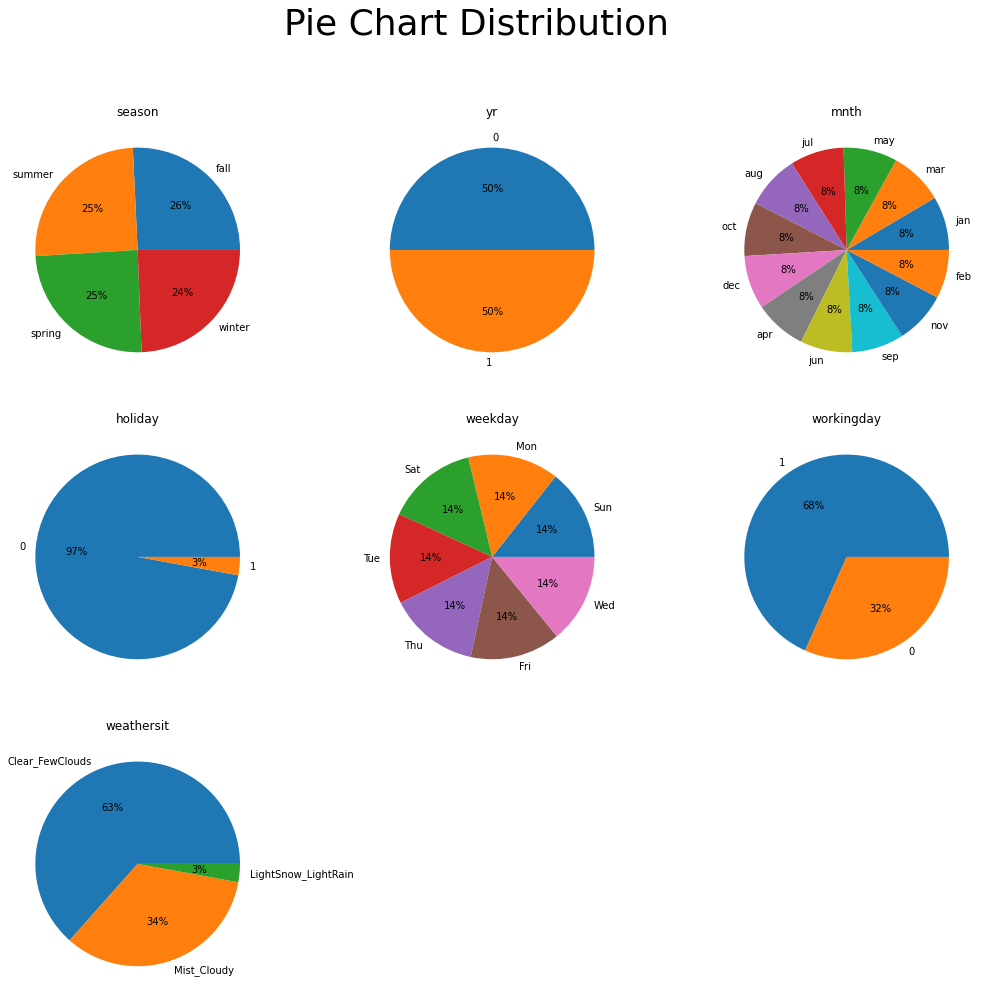

In [32]:

df_piplot=df.select_dtypes(include='category')

plt.figure(figsize=(18,16))
plt.suptitle('Pie Chart Distribution', fontsize=36)

for i in range(1,df_piplot.shape[1]+1):
    plt.subplot(3,3,i)
    f=plt.gca()
    f.set_title(df_piplot.columns.values[i-1])
    values=df_piplot.iloc[:,i-1].value_counts(normalize=True).values
    index=df_piplot.iloc[:,i-1].value_counts(normalize=True).index
    plt.pie(values,labels=index,autopct='%1.0f%%')
plt.show()

##### Pie Charts Explained 
- season: Operating in all four seasons
- yr: Operating pretty similar in both years
- month: Again operating pretty similar across all months
- holiday: Operating alot less in holidays (3%)
- weekday: Operating equally in all weekedays
- workingday: 68% in working days and 32% in non-working
- weathersit: Operating 63% in Clear/Few Cloud days, 34% in Mist/Cloudy Conditions, 3% in Light Snow/Rain Days, and nothing for the 4th category of Heavy Rain, Ice, Thunder, Mist, Snow & Fog

## Numerical Variables Visualisation

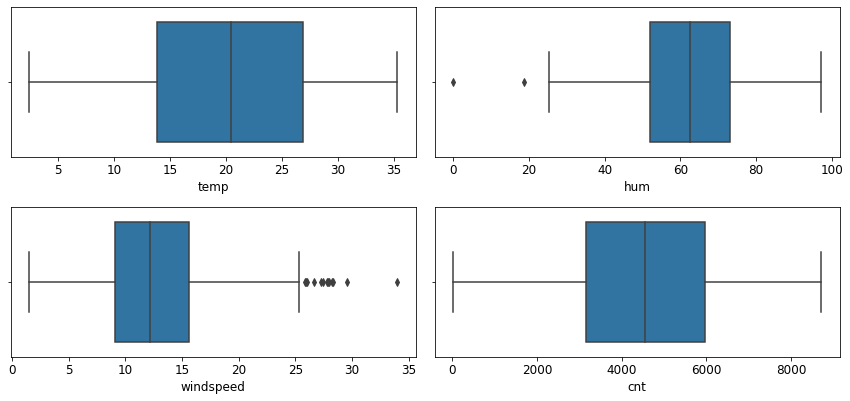

In [35]:
var = df.select_dtypes(exclude = 'category').columns

# Box plot
col = 2
row = len(var)//col+1

plt.figure(figsize=(12,8))
plt.rc('font', size=12)
for i in list(enumerate(var)):
    plt.subplot(row, col, i[0]+1)
    sns.boxplot(df[i[1]])    
plt.tight_layout()   
plt.show()

##### Plots Explained
- The above shows that there is very few outliers within the data for windspeed and hum, we can double check this by calculating the outlier percentage as shown below

In [37]:
def percentage_outlier(x):
    iqr = df[x].quantile(0.75)-df[x].quantile(0.25)
    HL = df[x].quantile(0.75)+iqr*1.5
    LL = df[x].quantile(0.25)-iqr*1.5
    per_outlier = ((df[x]<LL).sum()+(df[x]>HL).sum())/len(df[x])*100
    per_outlier = round(per_outlier,2)
    return(per_outlier)

print('Percentage of hum outliers: ', percentage_outlier('hum'))
print('Percentage of windspeed outliers: ', percentage_outlier('windspeed'))

Percentage of hum outliers:  0.27
Percentage of windspeed outliers:  1.78


As show above the percentage is rather low therefore i will keep the outliers as they are

## Demmand Visualised

We use the target variable of cnt over the entire period of two years to show the below data

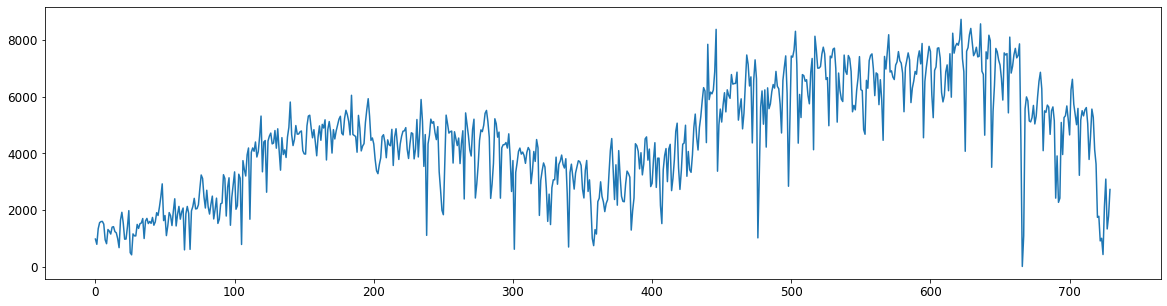

In [58]:
plt.figure(figsize=(20,5))
plt.plot(df.cnt)
plt.show()

##### Demmand Explained
- There was a good uptick of demmand over the past two years but there has been a reduction in demmand as of very recent. 

### Bivariate Analysis

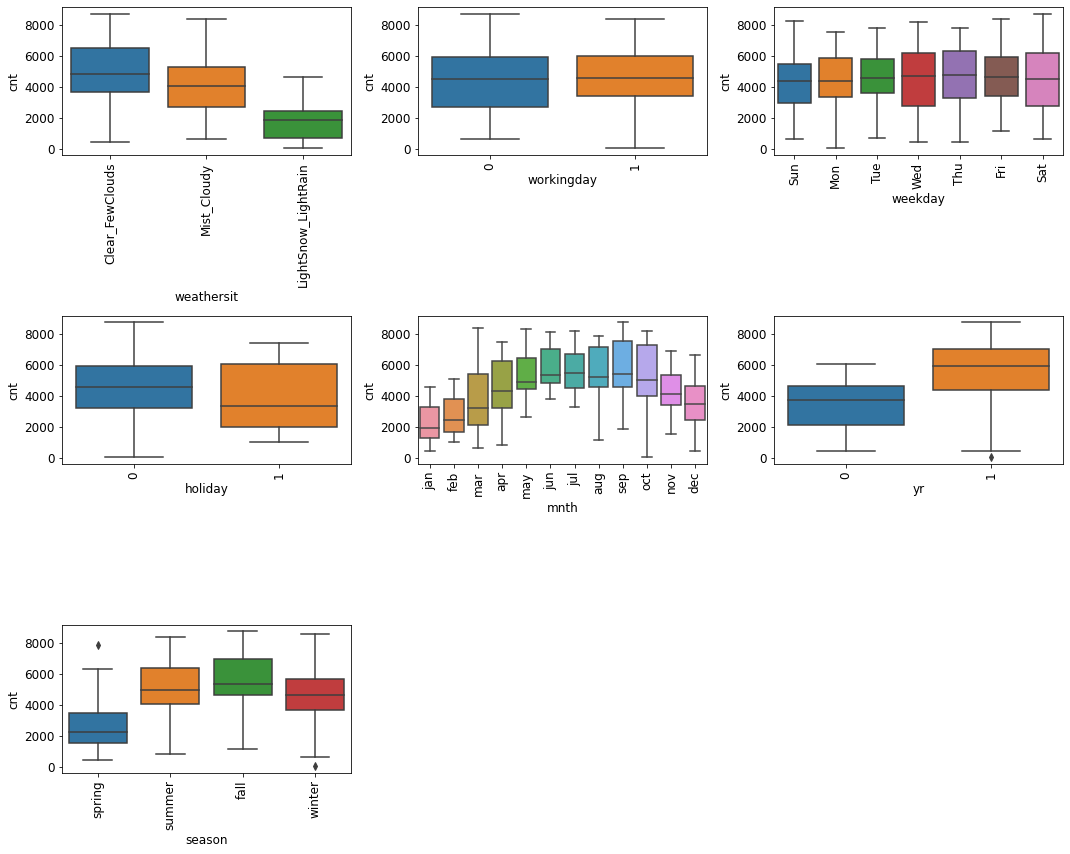

In [43]:
col = 3
row = len(c_vars)//col+1

plt.figure(figsize=(15,12))
for i in list(enumerate(c_vars)):
    plt.subplot(row,col,i[0]+1)
    sns.boxplot(x = i[1], y = 'cnt', data = df)
    plt.xticks(rotation = 90)
plt.tight_layout(pad = 1)    
plt.show()

##### Plots Explained
- Demmand increased in 2019 over 2018
- Demmand is similar for all weekdays
- Between working and nonworking day there is not much difference
- Demmand is higher during better weather days (Clear/Few Clouds)

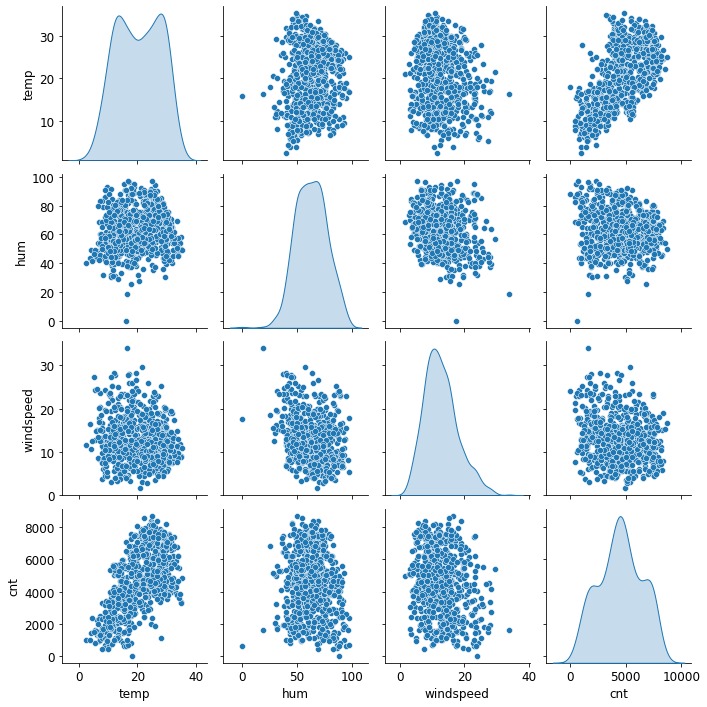

In [39]:
sns.pairplot(df.select_dtypes(['int64','float64']), diag_kind='kde')
plt.show()

##### Plots Explained
- There is a good correlation between temp and cnt

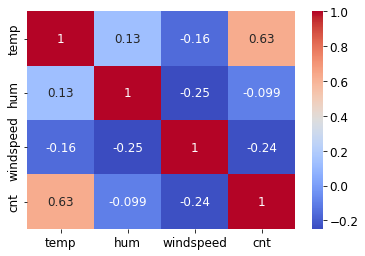

In [40]:
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

##### Heatmap Explained
- A correlation of 0.63 between temp and cnt which is high
- Negative correlations for hum and windspeed of -0.099 and -0.24 respectively

## Data Preparation

### Dummy Variables

In [59]:
# Here we will create dummy variables and drop some further columns
dummy_vars = pd.get_dummies(df[['season','weekday','mnth','weathersit']],drop_first=True)
df = pd.concat([df,dummy_vars], axis = 1)
df.drop(['season','weekday','mnth','weathersit'], axis=1, inplace=True)
df.head()

,yr,holiday,workingday,temp,hum,windspeed,cnt,season_summer,season_fall,season_winter,weekday_Mon,weekday_Tue,weekday_Wed,weekday_Thu,weekday_Fri,weekday_Sat,mnth_feb,mnth_mar,mnth_apr,mnth_may,mnth_jun,mnth_jul,mnth_aug,mnth_sep,mnth_oct,mnth_nov,mnth_dec,weathersit_Mist_Cloudy,weathersit_LightSnow_LightRain
0,0,0,0,14.110847,80.5833,10.749882,985,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,14.902598,69.6087,16.652113,801,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,1,8.050924,43.7273,16.636703,1349,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,8.200000,59.0435,10.739832,1562,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,9.305237,43.6957,12.522300,1600,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [60]:
df.shape

(730, 29)

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   yr                              730 non-null    category
 1   holiday                         730 non-null    category
 2   workingday                      730 non-null    category
 3   temp                            730 non-null    float64 
 4   hum                             730 non-null    float64 
 5   windspeed                       730 non-null    float64 
 6   cnt                             730 non-null    int64   
 7   season_summer                   730 non-null    uint8   
 8   season_fall                     730 non-null    uint8   
 9   season_winter                   730 non-null    uint8   
 10  weekday_Mon                     730 non-null    uint8   
 11  weekday_Tue                     730 non-null    uint8   
 12  weekday_Wed           

##### workingday, yr, and holiday are 0 or 1 variables but are showing as category type so we will convert them to uint8 first

In [62]:
# Change yr, holiday and workingday to numerical
df[['yr','holiday','workingday']]= df[['yr','holiday','workingday']].astype('uint8')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   yr                              730 non-null    uint8  
 1   holiday                         730 non-null    uint8  
 2   workingday                      730 non-null    uint8  
 3   temp                            730 non-null    float64
 4   hum                             730 non-null    float64
 5   windspeed                       730 non-null    float64
 6   cnt                             730 non-null    int64  
 7   season_summer                   730 non-null    uint8  
 8   season_fall                     730 non-null    uint8  
 9   season_winter                   730 non-null    uint8  
 10  weekday_Mon                     730 non-null    uint8  
 11  weekday_Tue                     730 non-null    uint8  
 12  weekday_Wed                     730 

### Split Data into two, Train and Test sets

In [64]:
df_train, df_test = train_test_split(df, train_size = 0.7, random_state = 10 )
print(df_train.shape)
print(df_test.shape)

(510, 29)
(220, 29)


### Scale Data
As shown in the visualisation part of this project there is a vast range of data in the set provided to us, thus we will need to scale the data with Min-Max Scaling on both the training and test datasets that we just split up

#### Scale Train Set

In [66]:
# Scale Train Set

scaler = MinMaxScaler()

# Fit + Transform on training data
df_train[n_vars] = scaler.fit_transform(df_train[n_vars])
df_train.head()

,yr,holiday,workingday,temp,hum,windspeed,cnt,season_summer,season_fall,season_winter,weekday_Mon,weekday_Tue,weekday_Wed,weekday_Thu,weekday_Fri,weekday_Sat,mnth_feb,mnth_mar,mnth_apr,mnth_may,mnth_jun,mnth_jul,mnth_aug,mnth_sep,mnth_oct,mnth_nov,mnth_dec,weathersit_Mist_Cloudy,weathersit_LightSnow_LightRain
72,0,0,1,0.298094,0.393891,0.236118,0.194978,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
510,1,0,0,0.778657,0.694105,0.364071,0.737052,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
700,1,0,0,0.327249,0.809877,0.210252,0.509236,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
264,0,0,1,0.694699,0.910249,0.217975,0.526862,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
577,1,0,1,0.811368,0.624004,0.244886,0.863093,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


#### Scale Test Set

In [68]:
# Check The Data First
df_test.head()

,yr,holiday,workingday,temp,hum,windspeed,cnt,season_summer,season_fall,season_winter,weekday_Mon,weekday_Tue,weekday_Wed,weekday_Thu,weekday_Fri,weekday_Sat,mnth_feb,mnth_mar,mnth_apr,mnth_may,mnth_jun,mnth_jul,mnth_aug,mnth_sep,mnth_oct,mnth_nov,mnth_dec,weathersit_Mist_Cloudy,weathersit_LightSnow_LightRain
566,1,0,0,24.429153,86.5417,14.291100,4459,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1
374,1,0,1,12.656536,64.6522,12.565984,3598,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
181,0,0,1,29.622500,39.6250,6.874736,5362,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
529,1,0,1,26.581653,56.9583,17.000111,7363,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
233,0,0,1,28.358347,47.0000,18.542250,4758,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [70]:
# And Now Transform
df_test[n_vars] = scaler.transform(df_test[n_vars])
df_test.head()

,yr,holiday,workingday,temp,hum,windspeed,cnt,season_summer,season_fall,season_winter,weekday_Mon,weekday_Tue,weekday_Wed,weekday_Thu,weekday_Fri,weekday_Sat,mnth_feb,mnth_mar,mnth_apr,mnth_may,mnth_jun,mnth_jul,mnth_aug,mnth_sep,mnth_oct,mnth_nov,mnth_dec,weathersit_Mist_Cloudy,weathersit_LightSnow_LightRain
566,1,0,0,0.652175,0.863516,0.393568,0.486297,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1
374,1,0,1,0.276477,0.584521,0.340487,0.382349,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
181,0,0,1,0.817910,0.265533,0.165370,0.595316,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
529,1,0,1,0.720868,0.486457,0.476922,0.836895,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
233,0,0,1,0.777567,0.359532,0.524373,0.522395,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


#### Split Data X/Y for Train and Test

In [71]:
# Create X/Y for Train Set
y_train = df_train.pop('cnt')
X_train = df_train
X_train.head()

,yr,holiday,workingday,temp,hum,windspeed,season_summer,season_fall,season_winter,weekday_Mon,weekday_Tue,weekday_Wed,weekday_Thu,weekday_Fri,weekday_Sat,mnth_feb,mnth_mar,mnth_apr,mnth_may,mnth_jun,mnth_jul,mnth_aug,mnth_sep,mnth_oct,mnth_nov,mnth_dec,weathersit_Mist_Cloudy,weathersit_LightSnow_LightRain
72,0,0,1,0.298094,0.393891,0.236118,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
510,1,0,0,0.778657,0.694105,0.364071,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
700,1,0,0,0.327249,0.809877,0.210252,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
264,0,0,1,0.694699,0.910249,0.217975,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
577,1,0,1,0.811368,0.624004,0.244886,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [72]:
# Create X/Y for Test Set
y_test = df_test.pop('cnt')
X_test = df_test

X_test.head()

,yr,holiday,workingday,temp,hum,windspeed,season_summer,season_fall,season_winter,weekday_Mon,weekday_Tue,weekday_Wed,weekday_Thu,weekday_Fri,weekday_Sat,mnth_feb,mnth_mar,mnth_apr,mnth_may,mnth_jun,mnth_jul,mnth_aug,mnth_sep,mnth_oct,mnth_nov,mnth_dec,weathersit_Mist_Cloudy,weathersit_LightSnow_LightRain
566,1,0,0,0.652175,0.863516,0.393568,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1
374,1,0,1,0.276477,0.584521,0.340487,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
181,0,0,1,0.817910,0.265533,0.165370,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
529,1,0,1,0.720868,0.486457,0.476922,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
233,0,0,1,0.777567,0.359532,0.524373,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


## Data Modelling, Analysis and Evaluation

In [73]:
X_train.columns

Index(['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed',
       'season_summer', 'season_fall', 'season_winter', 'weekday_Mon',
       'weekday_Tue', 'weekday_Wed', 'weekday_Thu', 'weekday_Fri',
       'weekday_Sat', 'mnth_feb', 'mnth_mar', 'mnth_apr', 'mnth_may',
       'mnth_jun', 'mnth_jul', 'mnth_aug', 'mnth_sep', 'mnth_oct', 'mnth_nov',
       'mnth_dec', 'weathersit_Mist_Cloudy', 'weathersit_LightSnow_LightRain'],
      dtype='object')

Now to run RFE to get variables and eliminate recursive features - we will select 15 in total

In [79]:
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm, step = 15)
rfe = rfe.fit(X_train, y_train)

col = X_train.columns[rfe.support_]
col

Index(['yr', 'temp', 'hum', 'windspeed', 'season_summer', 'season_fall',
       'season_winter', 'mnth_mar', 'mnth_apr', 'mnth_may', 'mnth_sep',
       'mnth_oct', 'weathersit_Mist_Cloudy', 'weathersit_LightSnow_LightRain'],
      dtype='object')

##### Make the model

In [81]:
# Using the RFE Selected Variables
X_train_rfe = X_train[col]

In [82]:
# Writing function for linear model stats
def sm_linearmodel(X_train_sm):
    #Add constant
    X_train_sm = sm.add_constant(X_train_sm)

    # create a fitted model (1st model)
    lm = sm.OLS(y_train,X_train_sm).fit()
    return lm

In [83]:
# Add for the VIF
def vif_calc(X):
    vif = pd.DataFrame()
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'],2)
    vif = vif.sort_values(by='VIF', ascending = False)
    return vif

##### Create Stats model and get summary plus VIF

In [86]:
lm_1 = sm_linearmodel(X_train_rfe)
print(lm_1.summary())

#VIF
print(vif_calc(X_train_rfe))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     186.4
Date:                Wed, 15 Jun 2022   Prob (F-statistic):          5.20e-187
Time:                        13:57:41   Log-Likelihood:                 481.06
No. Observations:                 510   AIC:                            -932.1
Df Residuals:                     495   BIC:                            -868.6
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

##### Remove P Value Variables

In [87]:
# >0.05 in bstep mannen and then do an update
pvalue = lm_1.pvalues
while(max(pvalue)>0.05):
    maxp_var = pvalue[pvalue == pvalue.max()].index
    print('Removed variable:' , maxp_var[0], '    P value: ', round(max(pvalue),3))
    
    # drop variable with high p value
    X_train_rfe = X_train_rfe.drop(maxp_var, axis = 1)
    lm_1 = sm_linearmodel(X_train_rfe)
    pvalue = lm_1.pvalues
    


Removed variable: mnth_apr     P value:  0.199
Removed variable: mnth_may     P value:  0.058


##### Explained
- The first loop removed mnth_apr at 0.199 as was >0.05 so was deemed insignificant
- The second loop removed mnth_may at 0.058 as was >0.05 so was deemed insignificant

In [88]:
# P Values for all will be < 0.05 so leets look for a summary and the VIF of lm_1
print(lm_1.summary())

# Calculate VIF
print(vif_calc(X_train_rfe))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     215.7
Date:                Wed, 15 Jun 2022   Prob (F-statistic):          3.25e-188
Time:                        14:02:35   Log-Likelihood:                 478.37
No. Observations:                 510   AIC:                            -930.7
Df Residuals:                     497   BIC:                            -875.7
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

##### Dropping hum 
We will drop hum due to its high VIF but not temp as during our EDA we saw that temp had a high correlation with cnt so it will still be relevant for our business understanding and analysis

In [89]:
X_train_new = X_train_rfe.drop(['hum'],axis = 1)

# Create stats model and look for summary
lm_2 = sm_linearmodel(X_train_new)
print(lm_2.summary())

# Calculate VIF
print(vif_calc(X_train_new))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     223.7
Date:                Wed, 15 Jun 2022   Prob (F-statistic):          1.12e-184
Time:                        14:05:40   Log-Likelihood:                 467.16
No. Observations:                 510   AIC:                            -910.3
Df Residuals:                     498   BIC:                            -859.5
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

##### Explained
- We have a R-Squared and a Adjusted R-Squared of 0.832 and 0.828 respectively and variables having a P val of <0.05. That means we should look into VIF more
- After dropping hum there is not a change to R-Squared in a significant amount so we were right in dropping it.
- The next highest is Season Fall which is 6.07 (>5) - We'll drop that next

In [90]:
# Drop and update
X_train_new = X_train_new.drop(['season_fall'],axis = 1)
lm_3 = sm_linearmodel(X_train_new)
print(lm_3.summary())


print(vif_calc(X_train_new))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     231.3
Date:                Wed, 15 Jun 2022   Prob (F-statistic):          3.39e-180
Time:                        14:10:15   Log-Likelihood:                 453.74
No. Observations:                 510   AIC:                            -885.5
Df Residuals:                     499   BIC:                            -838.9
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

##### Explained
- R-Squared and Adjusted R-Squared is still whereabouts it was previous at 0.823 and 0.812 respectively
- mnth_mar now has the highed P value so we'll drop and update yet again


In [91]:
# Drop and Update
X_train_new = X_train_new.drop(['mnth_mar'],axis = 1)
lm_4 = sm_linearmodel(X_train_new)
print(lm_4.summary())


print(vif_calc(X_train_new))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     253.4
Date:                Wed, 15 Jun 2022   Prob (F-statistic):          5.43e-180
Time:                        14:13:13   Log-Likelihood:                 450.38
No. Observations:                 510   AIC:                            -880.8
Df Residuals:                     500   BIC:                            -838.4
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

##### Explained
- R-Squared and Adjusted R-Squared is still whereabouts it was previous at 0.820 and 0.817 respectively
- mnth_oct now has the highed P value so we'll drop and update yet again


In [92]:
# Drop and Update
X_train_new = X_train_new.drop(['mnth_oct'],axis = 1)
lm_5 = sm_linearmodel(X_train_new)
print(lm_5.summary())


print(vif_calc(X_train_new))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     279.1
Date:                Wed, 15 Jun 2022   Prob (F-statistic):          3.69e-179
Time:                        14:14:23   Log-Likelihood:                 445.51
No. Observations:                 510   AIC:                            -873.0
Df Residuals:                     501   BIC:                            -834.9
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

##### Explained
- R-Squared and Adjusted R-Squared is still whereabouts it was previous at 0.817 and 0.814 respectively
- After looking at lm_4 aswell as lm_5 we will try reduce further by using lm_5 in our final model.
- All Variables at P Value 0


In [93]:
# Create Final Model
lm_final = lm_5
var_final = list(lm_final.params.index)
var_final.remove('const')
print('Final Selected Variables:', var_final)


print('\033[1m{:10s}\033[0m'.format('\nCoefficents:'))
print(round(lm_final.params,3))

Final Selected Variables: ['yr', 'temp', 'windspeed', 'season_summer', 'season_winter', 'mnth_sep', 'weathersit_Mist_Cloudy', 'weathersit_LightSnow_LightRain']

Coefficents:
const                             0.093
yr                                0.256
temp                              0.554
windspeed                        -0.139
season_summer                     0.094
season_winter                     0.142
mnth_sep                          0.094
weathersit_Mist_Cloudy           -0.084
weathersit_LightSnow_LightRain   -0.260
dtype: float64


##### Explained
- The variables given are as follows: 'yr', 'temp', 'windspeed', 'season_summer', 'season_winter', 'mnth_sep', 'weathersit_Mist_Cloudy', 'weathersit_LightSnow_LightRain'

#### Train Set Evaluation

In [95]:
X_train_res = X_train[var_final]

In [96]:
X_train_res = sm.add_constant(X_train_res)

In [97]:
y_train_pred = lm_final.predict(X_train_res)

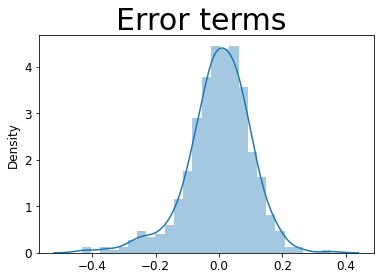

In [103]:
res = y_train - y_train_pred
sns.distplot(res)
plt.suptitle('Error terms', fontsize=30)
plt.show()

Error Terms show the mean to be at zero

Text(0.5, 0, 'Y_train_pred')

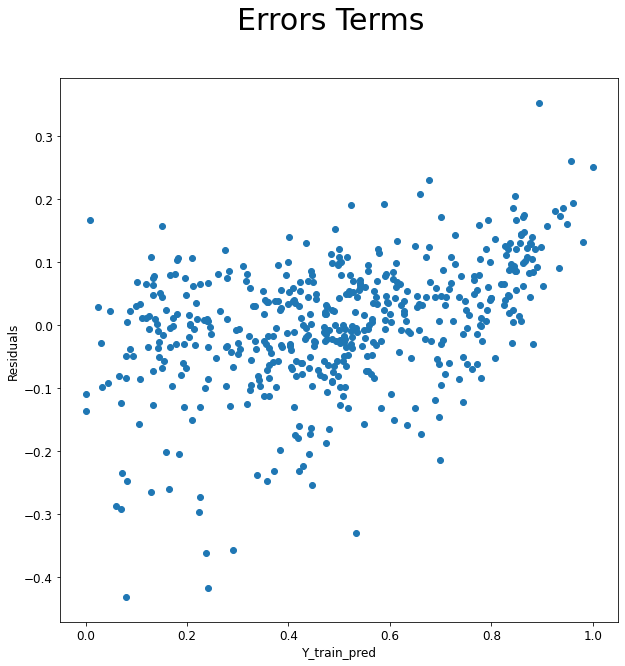

In [106]:
c = [i for i in range(1,len(y_train)+1,1)]
fig = plt.figure(figsize=(10,10))
fig.suptitle('Errors Terms', fontsize=30)  
plt.scatter(y_train,res)
  
plt.ylabel('Residuals', fontsize=12) 
plt.xlabel('Y_train_pred', fontsize=12)

### Prediction Time!

In [110]:
# Select some final variables from X_test
X_test_sm = X_test[var_final]
X_test_sm.head()

,yr,temp,windspeed,season_summer,season_winter,mnth_sep,weathersit_Mist_Cloudy,weathersit_LightSnow_LightRain
566,1,0.652175,0.393568,0,0,0,0,1
374,1,0.276477,0.340487,0,0,0,0,0
181,0,0.817910,0.165370,0,0,0,0,0
529,1,0.720868,0.476922,1,0,0,0,0
233,0,0.777567,0.524373,0,0,0,0,0


##### Constants

In [111]:
X_test_sm = sm.add_constant(X_test_sm)
X_test_sm.head()

,const,yr,temp,windspeed,season_summer,season_winter,mnth_sep,weathersit_Mist_Cloudy,weathersit_LightSnow_LightRain
566,1.0,1,0.652175,0.393568,0,0,0,0,1
374,1.0,1,0.276477,0.340487,0,0,0,0,0
181,1.0,0,0.817910,0.165370,0,0,0,0,0
529,1.0,1,0.720868,0.476922,1,0,0,0,0
233,1.0,0,0.777567,0.524373,0,0,0,0,0


##### Create Test Prediction Dataset

In [112]:
y_test_pred = lm_final.predict(X_test_sm)

#### Test Evaluate

In [114]:
r2_test = r2_score(y_true = y_test, y_pred = y_test_pred)
print('R-Squared: ', round(r2_test,3))

R-Squared:  0.813


In [118]:
N= len(X_test) 
p= len(var_final)
r2_test_adj = round((1-((1-r2_test)*(N-1)/(N-p-1))),3)
print('Adj. R-Squared: ', round(r2_test_adj,3))

Adj. R-Squared:  0.806


In [119]:
mse = mean_squared_error(y_test, y_test_pred)
print('Mean Error :' ,round(mse,4))

Mean Error : 0.0097


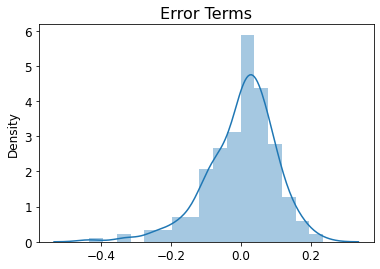

In [120]:
# Recheck Errors Terms
res_test = y_test - y_test_pred
plt.title('Error Terms', fontsize=16) 
sns.distplot(res_test)
plt.show()

Error distribution remains at zero here in the plot above

Text(0, 0.5, 'Residuals')

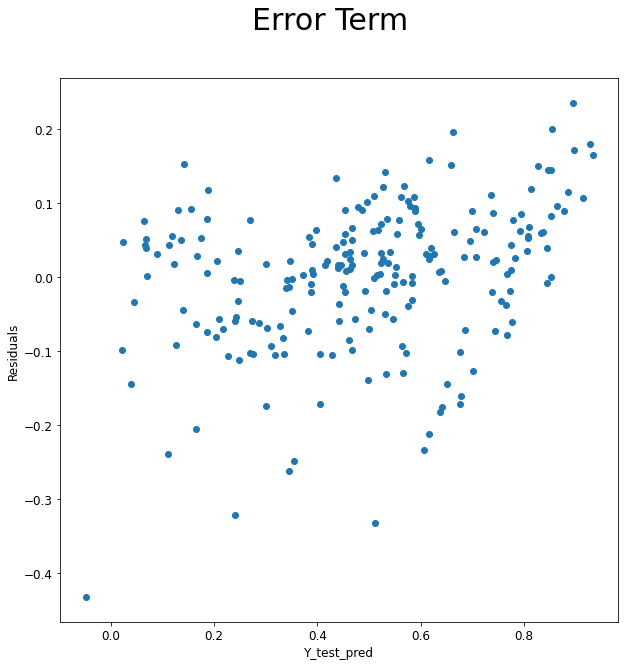

In [121]:
c = [i for i in range(1,len(y_test)+1,1)]
fig = plt.figure(figsize=(10,10))
fig.suptitle('Error Term', fontsize=30)

plt.scatter(y_test,res_test)
plt.xlabel('Y_test_pred', fontsize=12) 
plt.ylabel('Residuals', fontsize=12)   

##### Explained
- Graph appears to be randomised to a good degrees

##### What next
- We will now plot test and pred together from both y axis

Text(0, 0.5, 'y_test_pred')

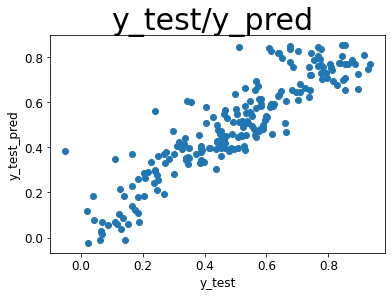

In [123]:
fig = plt.figure()
fig.suptitle('y_test/y_pred', fontsize = 30)

plt.scatter(y_test, y_test_pred)


plt.xlabel('y_test', fontsize = 12) 
plt.ylabel('y_test_pred', fontsize = 12)      

#### Whats this?
- from the chart above it would be a good explaination that when we used lm_5 it has a good/very good predictive power
- We will now use this data to draw up some kind of conclusion

In [125]:
print('R- Sqaured train: ', round(lm_final.rsquared,2), '  Adj. R-Squared trained:', round(lm_final.rsquared_adj,3) )
print('R- Sqaured test : ', round(r2_test,2), '  Adj. R-Squared from test :', round(r2_test_adj,3))

print(round(lm_final.params,3))

R- Sqaured train:  0.82   Adj. R-Squared trained: 0.814
R- Sqaured test :  0.81   Adj. R-Squared from test : 0.806
const                             0.093
yr                                0.256
temp                              0.554
windspeed                        -0.139
season_summer                     0.094
season_winter                     0.142
mnth_sep                          0.094
weathersit_Mist_Cloudy           -0.084
weathersit_LightSnow_LightRain   -0.260
dtype: float64


In [128]:
# As requrest by upGrad i have included the r2_score function output below but you will also see it above on second line
r2_score(y_test, y_test_pred)

0.8129833065740747

## Conclusion

### From the data above we can draw the following conclusion below:
- From the model above we can see that the top contributing factors to demmand usage are temp (@0.554) weathersit (@-0.260) & yr (@0.256)